# Particle spray algorithm by Chen et al. (2024) via `gala`

Author: Yingtian "Bill" Chen

We provide a notebook to generate streams using the Chen+24 ([arXiv:2408.01496](https://arxiv.org/abs/2408.01496)) model via `gala`. This implementation has been merged to the main branch of `gala` since version `v1.9`.

In [21]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import astropy.units as u
import astropy.coordinates as coord

import gala.coordinates as gc
import gala.potential as gp
import gala.dynamics as gd
from gala.dynamics import mockstream as ms
from gala.dynamics.nbody import DirectNBody
from gala.units import galactic, UnitSystem

import pandas as pd

#Reading GD1 data
df_desi = pd.read_csv('/Users/bsegovia/Downloads/brigette_code/GD-1/monica_code/All_table_at_fig4b_cleaned.csv')


### Set up galactic potential and initial conditions of the progenitor and the perturber (DM subhalo)

Here, we use the `MWPotential2014` potential by Bovy (2015).

In [22]:
pot = gp.BovyMWPotential2014(units=galactic)
static_frame = gp.StaticFrame(galactic) #new addition
# H = gp.Hamiltonian(pot) old hamiltonian
H = gp.Hamiltonian(potential=pot, frame=static_frame)

# #Define progenitor information old info
# prog_w0 = gd.PhaseSpacePosition(pos=[40, 0, 0] * u.kpc,
#                                 vel=[0, 100, 0] * u.km/u.s)

# Gaia coordinates of GD1 core IC in Standard Galactic Cartesian coordinates (from Koposov et al 2010):
prog_w0 = gd.PhaseSpacePosition(pos=[-3.41,13.00,9.58]*u.kpc,
                           vel=[-200.4,-162.6,13.9]*u.km/u.s)
prog_mass = 1e5 * u.Msun


#Define DM subhalo information
perturber_w0 = gd.PhaseSpacePosition(pos=[-4.41,13.00,9.58]*u.kpc,
                           vel=[-195.4,-162.6,13.9]*u.km/u.s)
#old values below
# perturber_w0 = gd.PhaseSpacePosition(pos=[41, 0, 0] * u.kpc, 
#                                      vel=[-10, 100, 0] * u.km/u.s)
perturber_mass = 1e6 * u.Msun

#Define the combined initial conditions
w0_combined = gd.combine((prog_w0, perturber_w0))

### Generate streams!

Here is the case of backward integration, which is more commonly used for stream modeling. But you can do forward integration by simply fliping the sign of `dt`.

Specifics on run() : [https://gala.adrian.pw/en/latest/api/gala.dynamics.mockstream.MockStreamGenerator.html#gala.dynamics.mockstream.MockStreamGenerator.run ] 

Specifics on nbody : 
[https://gala.adrian.pw/en/latest/dynamics/nbody.html ]

In [4]:
#Potentials 
prog_pot = gp.PlummerPotential(m=prog_mass, b=4*u.pc, units=galactic) #progenitor monica uses b=.3*u.kpc

perturber_pot = gp.PlummerPotential(m=perturber_mass, b=4*u.pc, units=galactic) #DM  #MAYBE A cuspy potential 
tot_pot = [prog_pot, perturber_pot]

In [5]:
perturber = gd.DirectNBody(perturber_w0, [perturber_pot], external_potential=pot)


In [9]:
df = ms.ChenStreamDF()
gen = ms.MockStreamGenerator(df, H, progenitor_potential=prog_pot) #there's no more arguments here

#nbody=nbody of DM because this is how many other objects can affect the stream

#release every 10 instead of 1 (monicas code uses 10)
stream, prog = gen.run(prog_w0=prog_w0, prog_mass=prog_mass, nbody=perturber, release_every=5, n_particles=1, 
                                 output_every=True, output_filename='snapshots_new', check_filesize=True, overwrite=True, 
                                 progress=False, dt=-10*u.Myr, n_steps=500)#[source]



In [10]:
#used for color
stream_icrs_color = stream.to_coord_frame(coord.ICRS())
gd1_sim_color = stream_icrs_color.transform_to(gc.GD1Koposov10())


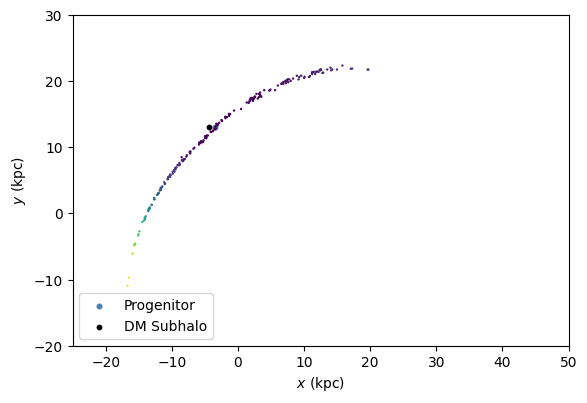

In [11]:
plt.scatter(prog.pos.x.value[0], prog.pos.y.value[0], color='steelblue', s=11, alpha=1, label = 'Progenitor')
plt.scatter(prog.pos.x.value[1], prog.pos.y.value[1], color='black', s=10, alpha=1, label = 'DM Subhalo')
plt.scatter(stream.pos.x.value, stream.pos.y.value, c=gd1_sim_color.radial_velocity.to_value('km/s'), s=0.5, alpha=1) #, label='With perturber')

plt.xlabel(r'$x\ ({\rm kpc})$')
plt.ylabel(r'$y\ ({\rm kpc})$')
plt.xlim(-25, 50)
plt.ylim(-20, 30)
plt.legend(loc='lower left')
plt.gca().set_aspect(1)
plt.show()

### Generate the movie!

In [12]:
import h5py    

f1 = h5py.File('snapshots_new','r+')    
f1

<HDF5 file "snapshots_new" (mode r+)>

In [13]:
import h5py

# Open the HDF5 file
with h5py.File('snapshots_new', 'r') as f:
    # Print all groups and datasets within the file
    def print_attrs(name, obj):
        print(f"{name}: {obj}")

    f.visititems(print_attrs)


nbody: <HDF5 group "/nbody" (3 members)>
nbody/pos: <HDF5 dataset "pos": shape (3, 501, 2), type "<f8">
nbody/time: <HDF5 dataset "time": shape (501,), type "<f8">
nbody/vel: <HDF5 dataset "vel": shape (3, 501, 2), type "<f8">
stream: <HDF5 group "/stream" (3 members)>
stream/pos: <HDF5 dataset "pos": shape (3, 501, 202), type "<f8">
stream/time: <HDF5 dataset "time": shape (501,), type "<f8">
stream/vel: <HDF5 dataset "vel": shape (3, 501, 202), type "<f8">


In [14]:
# Set the path to the ffmpeg binary
mpl.rcParams['animation.ffmpeg_path'] = '/opt/homebrew/bin/ffmpeg'  # Adjust if ffmpeg is elsewhere


In [15]:
# np.shape(prog_pos[:,:,0]), 
with h5py.File('snapshots_new', 'r') as f:
    a = f['nbody/pos'][:]

np.shape(a)

(3, 501, 2)

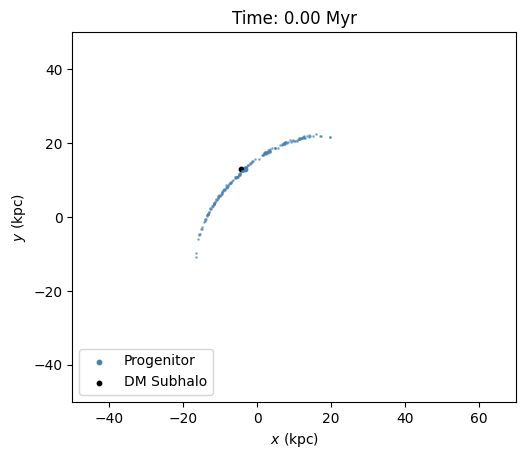

In [16]:
# Load the HDF5 file
with h5py.File('snapshots_new', 'r') as f:
    # Load the position and time data for the progenitor and stream
    # prog_pos = f['nbody/pos'][:]  # Progenitor positions, shape (3, 501, 2)
    prog_pos = f['nbody/pos'][:,:,0]
    perturber_pos = f['nbody/pos'][:,:,1]
    stream_pos = f['stream/pos'][:]  # Stream positions, shape (3, 501, 1002)
    time_data = f['nbody/time'][:]  # Time steps, shape (501,)

# Create a figure for the animation
fig, ax = plt.subplots()

# Initialize scatter plots for progenitor and stream
prog_scatter = ax.scatter([], [], color='steelblue', s=10, alpha=1, label = 'Progenitor')
perturber_scatter = ax.scatter([], [], color='black', s=10, alpha=1, label = 'DM Subhalo')
stream_scatter = ax.scatter([], [], color='steelblue', s=1, alpha=0.5)

# Set plot labels and aspect ratio
ax.set_xlabel(r'$x\ ({\rm kpc})$')
ax.set_ylabel(r'$y\ ({\rm kpc})$')
ax.set_aspect(1)
ax.legend(loc='lower left')

# Set the limits for the x and y axes
ax.set_xlim(-50, 70) #(-50, 50)
ax.set_ylim(-50, 50) #(-50, 50)

# Update function for each frame in the animation
def update(frame):
    # Clear previous scatter points
    # prog_scatter.set_offsets(prog_pos[:2, frame, :].T)
    prog_scatter.set_offsets(prog_pos[:2, frame].T)
    perturber_scatter.set_offsets(perturber_pos[:2, frame].T)
    stream_scatter.set_offsets(stream_pos[:2, frame, :].T)

    ax.set_title(f"Time: {time_data[frame]:.2f} Myr")

# Create the animation
ani = FuncAnimation(fig, update, frames=len(time_data), interval=50)

# Save the animation as a video file
ani.save('stream_simulation_new.mp4', writer='ffmpeg')

# Show the plot
plt.show()

In [17]:
stream_icrs = stream.to_coord_frame(coord.ICRS())
prog_icrs = prog.to_coord_frame(coord.ICRS())
stream_gc = stream.to_coord_frame(coord.Galactic())
prog_gc = stream.to_coord_frame(coord.Galactic())

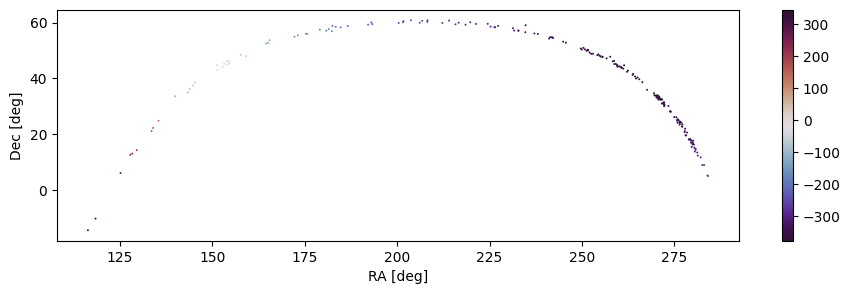

In [18]:
# ------- Figure object --------------------------------------------------------
fig = plt.figure()
fig.set_figheight(3) 
fig.set_figwidth(11)
plt.subplot(111)
cs = plt.scatter(
    stream_icrs.ra.degree,
    stream_icrs.dec.degree,
    marker='o', linewidth=0, s=2, 
    c=stream_icrs.radial_velocity.value, cmap='twilight_shifted')
plt.xlabel('RA [deg]')
plt.ylabel('Dec [deg]')
plt.colorbar(cs)
#plt.colorbar(cs)
# plt.savefig('trial_stream_cart.png')


#range of masses, gc and subh 

In [19]:
phi1 = df_desi['phi_1'] * u.rad
phi2 = df_desi['phi_2'] * u.rad

gd1_sim = stream_icrs.transform_to(gc.GD1Koposov10())

/var/folders/6w/4l8xsqjn63b50789db29p6tm0000gr/T/ipykernel_91032/4074641377.py:24: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc1=ax.scatter(phi1, phi2, color='red', marker='.', s=50, cmap='tab20b',label='Observed')


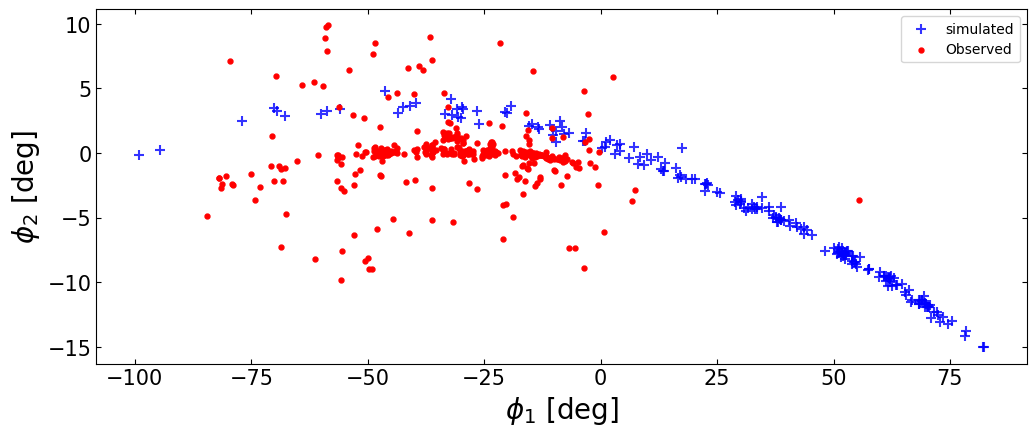

In [20]:
#sample  scatter plot:
# ------- Figure object
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(11)
    
# ------- Axis object
ax = plt.subplot(1,1,1)
ax.tick_params(axis='both',which='both',direction='in',
                   labelsize=15,right=True,top=True)
#ax.xaxis.set_ticks(np.arange(-400,400, step=100.))
#ax.yaxis.set_ticks(np.arange(-400,400, step=100.))
ax.set_xlabel(r'$\phi_1$ [deg]',fontsize=20)
ax.set_ylabel(r'$\phi_2$ [deg]',fontsize=20)

#ax.set_xlim(-420.,420.)

# ax.set_ylim(-10.,10.)
# ax.set_xlim(-90, 5.)
ax.scatter(gd1_sim.phi1, gd1_sim.phi2, marker='+', s=50,color='blue', alpha = 0.8, label='simulated')
#c=gd1sim_dvel.to_value(u.km / u.s)

# ------- Plot
sc1=ax.scatter(phi1, phi2, color='red', marker='.', s=50, cmap='tab20b',label='Observed') 
#               vmin=-150., vmax=150.,edgecolor='none',alpha=0.8)
#c=dvel

# # ------- Colorbar
# divider = make_axes_locatable(ax)
# cax = divider.append_axes("right", size="5%",pad ="2%")
# cbar = plt.colorbar(sc1,cax=cax)
# cbar.ax.tick_params(labelsize=15)
# cbar.set_label(r'$\delta v_{GSR}$ [km s$^{-1}$]',fontsize=20,
#     ha='center',va='center', labelpad=10)
# cbar.solids.set(alpha=1)
#ax.scatter([],[], c='magenta',edgecolor='white',marker='o',s=100,label='somelabel')
ax.legend()
ax.grid(False)



ax.grid(False)
fig.tight_layout(pad=3.0)
plt.savefig('GD1_sim_dat.png')
plt.show()
plt.close()

## Looking at Conversion Problem

In [ ]:
#TESTING
stream_gal_test = stream_icrs.transform_to(Galactocentric())
gd1_sim_test = stream_gal_test.transform_to(gc.GD1Koposov10())

In [167]:
#TESTING
stream_test = stream_icrs.vhel_to_vgsr(coordinate, vhel, vsun)
gd1_sim_test = stream_test.transform_to(gc.GD1Koposov10())



#sample  scatter plot:
# ------- Figure object
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(11)
    
# ------- Axis object
ax = plt.subplot(1,1,1)
ax.tick_params(axis='both',which='both',direction='in',
                   labelsize=15,right=True,top=True)
#ax.xaxis.set_ticks(np.arange(-400,400, step=100.))
#ax.yaxis.set_ticks(np.arange(-400,400, step=100.))
ax.set_xlabel(r'$\phi_1$ [deg]',fontsize=20)
ax.set_ylabel(r'$\phi_2$ [deg]',fontsize=20)

#ax.set_xlim(-420.,420.)

# ax.set_ylim(-10.,10.)
# ax.set_xlim(-90, 5.)
ax.scatter(gd1_sim.phi1, gd1_sim.phi2, marker='+', s=50,color='blue', alpha = 0.8, label='simulated')
#c=gd1sim_dvel.to_value(u.km / u.s)

# ------- Plot
sc1=ax.scatter(phi1, phi2, color='red', marker='.', s=50, cmap='tab20b',label='Observed') 

ax.legend()
ax.grid(False)



ax.grid(False)
fig.tight_layout(pad=3.0)
plt.savefig('GD1_sim_dat.png')
plt.show()
plt.close()

#
#
#
#
#
#
#
#

## If you have agama installed, the following compares the action space distribution

import agama # to calculate action
agama.setUnits(length=1, velocity=1, mass=1) # working units: 1 Msun, 1 kpc, 1 km/s

actFinder = agama.ActionFinder(agama.Potential('data/MWPotential2014.ini'))

def get_action(stream, prog, actFinder):
    pos_prog = prog.pos.xyz.to('kpc').value
    vel_prog = prog.vel.d_xyz.to('km/s').value
    posvel_prog = np.r_[pos_prog.squeeze(),vel_prog.squeeze()]
    action_prog = actFinder(posvel_prog)
    Jphi_prog = action_prog[2]
    Jr_prog = action_prog[0]
    
    pos = stream.pos.xyz.to('kpc').value
    vel = stream.vel.d_xyz.to('km/s').value
    posvel = np.column_stack((pos.T,vel.T))
    actions = actFinder(posvel)
    Jphi = actions[:,2]
    Jr = actions[:,0]
    
    # DLtot = Ltot - Ltot_prog
    DJphi = Jphi - Jphi_prog
    DJr = Jr - Jr_prog
    return DJphi, DJr
    
DJphi, DJr = get_action(stream_f15, prog_f15, actFinder)
plt.scatter(DJphi, DJr, s=1, alpha=0.5, label='Fardal+15')

DJphi, DJr = get_action(stream_c24, prog_c24, actFinder)
plt.scatter(DJphi, DJr, s=1, alpha=0.5, label='Chen+24 no prog.')

DJphi, DJr = get_action(stream_c24b, prog_c24b, actFinder)
plt.scatter(DJphi, DJr, s=1, alpha=0.5, label='Chen+24 with prog.')

plt.xlabel(r'$\Delta J_\phi\ ({\rm kpc\,km/s})$')
plt.ylabel(r'$\Delta J_r\ ({\rm kpc\,km/s})$')
plt.xlim(-120, 120)
plt.ylim(-100, 100)
plt.legend(loc='lower right')
plt.gca().set_aspect(1)
plt.show()